# [Predict the onset of diabetes based on diagnostic measures](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

## Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.](https://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC2245318&blobtype=pdf)

## Variables

- **Pregnancies**: Number of times pregnant

- **Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

- **BloodPressur**e: Diastolic blood pressure (mm Hg)

- **SkinThickness**: Triceps skin fold thickness (mm)

- **Insulin**: 2-Hour serum insulin (mu U/ml)

- **BMI**: Body mass index (weight in kg/(height in m)^2)

- **DiabetesPedigreeFunction**: Diabetes pedigree function

- **Age**: Age (years)

- **Outcome**: Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

In [2]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")
for i in range(num_gpus):
    print(f"{i+1}. GPU {i}: {torch.cuda.get_device_name(i)}")

device = 0  # "Select the index of the GPU you wish to use"
torch.cuda.set_device(device)
print(f"GPU selection: {torch.cuda.get_device_name(device)}")

device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device1}")

Number of GPUs available: 1
1. GPU 0: NVIDIA GeForce MX110
GPU selection: NVIDIA GeForce MX110
Using device: cuda:0


## Load data

In [3]:
data = pd.read_csv("../../data/diabetes.csv")

## Check any missing values

In [4]:
data.describe()
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
col_entradas = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]
col_salidas = [
    "Outcome"
]

In [6]:
data[col_salidas].head()

,Outcome
0,1
1,0
2,1
3,0
4,1


## Explore the data relationship

<Axes: xlabel='Outcome', ylabel='count'>

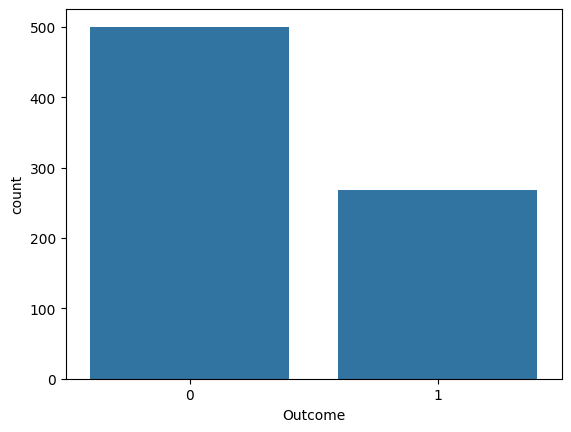

In [7]:
sns.countplot(data=data, x="Outcome")

## Normalize and standarize the data

In [8]:
standarScaler_features = StandardScaler().fit(data[col_entradas])
entradas_norm = standarScaler_features.transform(data[col_entradas])
salida_norm = data[col_salidas].values


## Create neural network data

### Create Dataset

In [9]:
class TabularDataset(Dataset):
    def __init__(self, ent, sal):
        self.inputs = torch.tensor(ent, dtype=torch.float32)
        self.outputs = torch.tensor(sal, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [10]:
conjuntoDatos = TabularDataset(ent=entradas_norm, sal=salida_norm)

train_ds, val_ds, test_ds = random_split(conjuntoDatos, [0.7, 0.15, 0.15])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [11]:
for batch in train_loader:
    X_batch, y_batch = batch
    print(X_batch.shape, y_batch.shape)

torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([32, 8]) torch.Size([32, 1])
torch.Size([26, 8]) torch.Size([26, 1])


## Train model

In [12]:
class RedNeuronal(nn.Module):
    def __init__(self, ent, sal):
        super(RedNeuronal, self).__init__()
        self.num_caract = ent
        self.num_salidas = sal
        self.fc1 = nn.Linear(self.num_caract, 10)  # Capa oculta 1
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(10, 12) # Capa oculta 2
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(12, 13)  # Capa oculta 3
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(13, self.num_salidas)  # Capa de salida
        self.act4 = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.act4(self.fc4(x))
        return x

In [13]:
epocas = 1000  # Número de épocas de entrenamiento
batch_size = 32  # Tamaño del lote

In [14]:
red = RedNeuronal(8, 1)
red = red.to(device=device1)

In [15]:
print(red.parameters())

<generator object Module.parameters at 0x7f7ae23a5ee0>


In [16]:
criterio = nn.BCELoss()
optimizador = optim.Adam(red.parameters(), lr=0.001)

In [17]:
# Entrenar la red neuronal
for epoca in range(epocas):
    perdida_entrenamiento = 0
    for X_batch, y_batch in train_loader:
        # Pasar los datos por la red neuronal
        salida = red(X_batch.to(device=device1))

        # Calcular la pérdida
        perdida = criterio(salida, y_batch.to(device=device1))

        # Actualizar los pesos
        optimizador.zero_grad()
        perdida.backward()
        optimizador.step()
        perdida_entrenamiento += perdida.item()

    # Imprimir la pérdida en cada época
    #print(f"Época {epoca+1}, pérdida: {perdida.item():.8f}")
    perdida_validacion = 0
    con_exactitud = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Pasar los datos por la red neuronal
            salida = red(X_batch.to(device=device1))

            # Calcular la pérdida
            perdida = criterio(salida, y_batch.to(device=device1))

            perdida_validacion += perdida.item()

            # Calcular la exactitud
            _, predicciones = torch.max(salida, 1)
            con_exactitud += (predicciones.cpu().numpy() == y_batch.cpu().numpy()).sum().item()
            total += y_batch.shape[0]

    # Imprimir los resultados
    print(f"Época {epoca+1}")
    print(f"Perdida entrenamiento: {perdida_entrenamiento/len(train_loader)}")
    print(f"Perdida validación: {perdida_validacion/len(val_loader)}")
    print(f"Exactitud validación: {con_exactitud/total:.4f}")

Época 1
Perdida entrenamiento: 0.6791575761402354
Perdida validación: 0.6788250803947449
Exactitud validación: 18.0609
Época 2
Perdida entrenamiento: 0.672294301145217
Perdida validación: 0.6751690059900284
Exactitud validación: 18.4000
Época 3
Perdida entrenamiento: 0.6647399173063391
Perdida validación: 0.6713864207267761
Exactitud validación: 18.7391
Época 4
Perdida entrenamiento: 0.6535137961892521
Perdida validación: 0.6575797200202942
Exactitud validación: 18.4000
Época 5
Perdida entrenamiento: 0.6389946797314812
Perdida validación: 0.6436730623245239
Exactitud validación: 18.2870
Época 6
Perdida entrenamiento: 0.6213853324160856
Perdida validación: 0.6348690390586853
Exactitud validación: 18.6261
Época 7
Perdida entrenamiento: 0.5960922311334049
Perdida validación: 0.6058164685964584
Exactitud validación: 18.5130
Época 8
Perdida entrenamiento: 0.5712940009201274
Perdida validación: 0.5880416631698608
Exactitud validación: 18.7391
Época 9
Perdida entrenamiento: 0.5457583104862886

## Eval Model